In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# prepare data (X,Y) ~ ((p1, p2), {0,1})
def prepare_data(path):
    data = np.load(path)
    
    data = data.transpose((0, 4, 2, 3, 1))
    data = data.reshape(data.shape[0], 15, 15, 2)
    
    # normalization
    mean = np.mean(data)
    std  = np.std(data)
    data = (data - mean)/(std+1e-7)
    
    return data

In [3]:
# get data
data_neg = prepare_data('/content/gdrive/My Drive/data/stereo_matching/cosine_1.npy') #negative
print(data_neg.shape)

data_pos = prepare_data('/content/gdrive/My Drive/data/stereo_matching/cosine_2.npy') #positive
print(data_pos.shape)

# get labels
Y_neg = np.zeros((data_neg.shape[0],))
print(Y_neg.shape)

Y_pos = np.ones((data_neg.shape[0],))
print(Y_pos.shape)

(1000000, 15, 15, 2)
(1000000, 15, 15, 2)
(1000000,)
(1000000,)


In [4]:
Y_neg = Y_neg.reshape(-1, 1)
print(Y_neg.shape)

Y_pos = Y_pos.reshape(-1, 1)
print(Y_pos.shape)

Y = np.array([Y_neg, Y_pos])
Y = np.vstack(Y)
Y = Y.squeeze()
print(Y.shape)

(1000000, 1)
(1000000, 1)
(2000000,)


In [5]:
data = np.array([data_neg, data_pos])
data = np.vstack(data)
print(data.shape)

(2000000, 15, 15, 2)


In [6]:
# shuffle
data_size = data.shape[0]

rng = np.random.RandomState(113)
indices = np.arange(data_size)

rng.shuffle(indices)
data = data[indices]
Y = Y[indices]

In [7]:
# 2. Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
import tensorflow as tf

def base_model(input_shape):
    inputs = Input(shape=input_shape)

    # feature network
    x = Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x) # (bs, 1, 1, 32)

    # metric learning
    x = Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.squeeze(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

In [13]:
model = base_model((None, None, 2))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 32)    96        
_________________________________________________________________
batch_normalization_10 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, None, None, 32)    128 

In [14]:
X_test = tf.random.normal((64, 300, 300, 2))
Y_test = tf.random.normal((64,))

print(X_test.shape)
print(Y_test.shape)

(64, 300, 300, 2)
(64,)


In [15]:
# predict
pred = model(X_test)

# loss
print(pred.shape)
print(Y_test.shape)

(64, 286, 286)
(64,)


In [ ]:
# training
batch_size = 512
epochs = 30

opt_adam = keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt_adam)
history = model.fit(data, Y, batch_size = batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/30
3125/3125 [==============================] - 117s 37ms/step - loss: 0.0596 - val_loss: 0.0561
Epoch 2/30
3125/3125 [==============================] - 114s 36ms/step - loss: 0.0070 - val_loss: 0.1868
Epoch 3/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 4/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0034 - val_loss: 0.0260
Epoch 5/30
3125/3125 [==============================] - 112s 36ms/step - loss: 0.0015 - val_loss: 0.0073
Epoch 6/30
3125/3125 [==============================] - 112s 36ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 7/30
3125/3125 [==============================] - 113s 36ms/step - loss: 9.6735e-04 - val_loss: 3.2507e-04
Epoch 8/30
3125/3125 [==============================] - 113s 36ms/step - loss: 7.1118e-04 - val_loss: 3.7999e-04
Epoch 9/30
3125/3125 [==============================] - 113s 36ms/step - loss: 5.4469e-04 - val_loss: 1.3485e-04
Epoch 10/30
3125/3125 [========

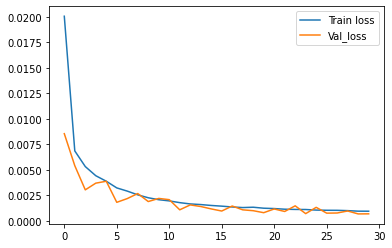

In [ ]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.legend()

In [ ]:
#Save model to cosin.h5 file
model.save('/content/gdrive/My Drive/data/stereo_matching/model_2channels.h5')